In [ ]:
# # Run this cell if you haven't installed yahoo finance library
# pip install yfinance

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

In [2]:
#Define ticker and start date for stock
#End date is latest by default

ticker = 'TSLA' #stock
start_date = '2010-01-01'

# Fetch data
data = yf.download(ticker, start=start_date)
data.columns = [col[0] for col in data.columns]

[*********************100%***********************]  1 of 1 completed


In [3]:
data.tail()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-11-04 00:00:00+00:00,242.839996,242.839996,248.899994,238.880005,244.559998,68802400
2024-11-05 00:00:00+00:00,251.440002,251.440002,255.279999,246.210007,247.339996,69282500
2024-11-06 00:00:00+00:00,288.529999,288.529999,289.589996,275.619995,284.670013,165228700
2024-11-07 00:00:00+00:00,296.910004,296.910004,299.750000,285.519989,288.890015,117309200
2024-11-08 00:00:00+00:00,321.220001,321.220001,328.709991,297.660004,299.140015,203590100


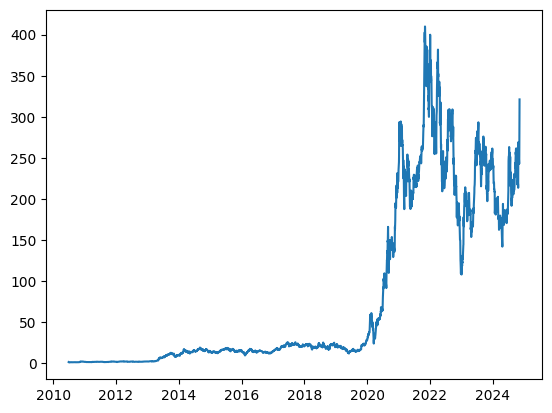

In [4]:
plt.plot(data['Close'])

In [5]:
#We will predict based on close price for stocks
new_data = data['Close']
new_data.shape

(3617,)

In [6]:
#Augmented dickey fuller test
output = adfuller(new_data, autolag='AIC')
print(f'ADF Statistic: {output[0]}')
print(f'p-value: {output[1]}')
print(f'Lags Used: {output[2]}')
print(f'Number of Observations Used: {output[3]}')
print('Critical Values:')
for key, value in output[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.5610320768387368
p-value: 0.8795463424461344
Lags Used: 29
Number of Observations Used: 3587
Critical Values:
   1%: -3.43217436182052
   5%: -2.862346100776558
   10%: -2.567199100391876


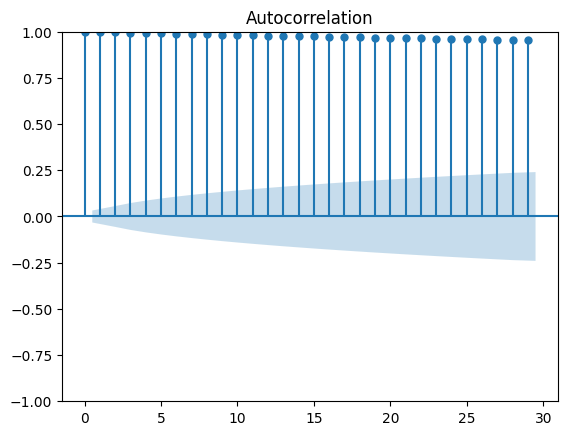

In [7]:
# ADF statistic suggests presence of non-stationarity/trend
acf = plot_acf(data['Close'],lags = 29)

In [8]:
differenced_data = new_data.diff().dropna()

In [9]:
#dickey fuller test
output = adfuller(differenced_data, autolag='AIC')
print(f'ADF Statistic: {output[0]}')
print(f'p-value: {output[1]}')
print(f'Lags Used: {output[2]}')
print(f'Number of Observations Used: {output[3]}')
print('Critical Values:')
for key, value in output[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -10.555943455971363
p-value: 7.952205735576977e-19
Lags Used: 30
Number of Observations Used: 3585
Critical Values:
   1%: -3.432175380325744
   5%: -2.862346550668757
   10%: -2.5671993399002897


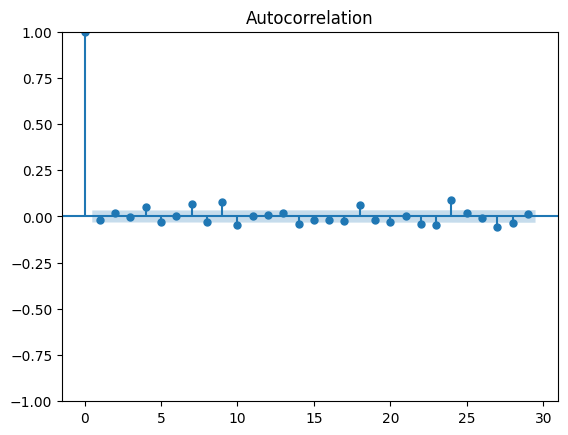

In [11]:
# ADF test statistic suggests that now stationarity is absent
acf = plot_acf(differenced_data,lags = 29)

In [12]:
# BUT..... we need non-stationarity/trend in data so that LSTM model can learn pattern/trend in data
# So we use original non differenciated data

In [13]:
#Scale the data
scaler = MinMaxScaler()
sc_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))

#Split data into train and test
train = sc_data[:int(0.8*len(sc_data))] #80%
test = sc_data[int(0.8*len(sc_data)):] #20%

print(f"Length of train data:{len(train)}, Length of test data:{len(test)}")

#Convert an array of values into a dataset matrix
# dataX[i] = [dataX[i], dataX[i+1], dataX[i+2], ...., dataX[i+time_step]]
# dataY[i] = dataX[i+time_step+1]
# Use previous time_step values (X) as training features and (time_step+1)th value (Y) as label

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

#We will use previous 50 values as lags/training features
timestamps = 50
x_train, y_train = create_dataset(train, timestamps)
x_test, y_test = create_dataset(test, timestamps)

print(f"Train data shape: {x_train.shape}, Test data shape: {x_test.shape}")

Length of train data:2893, Length of test data:724
Train data shape: (2842, 50), Test data shape: (673, 50)


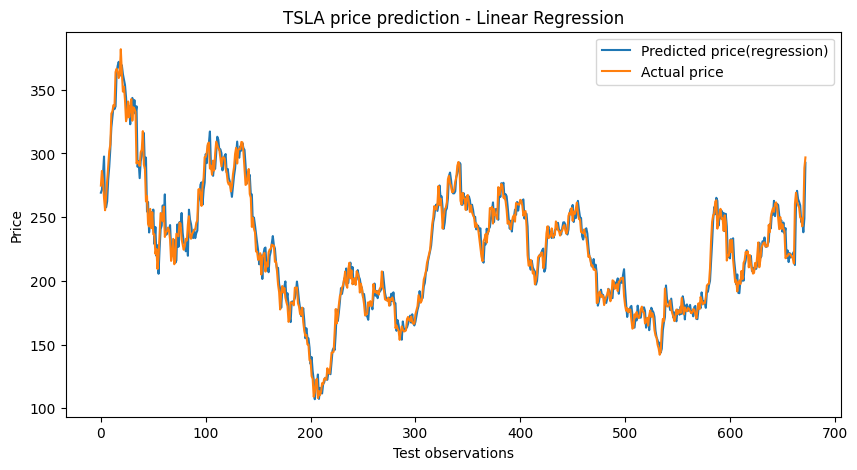

In [20]:
#Linear regression model without any penalty
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# Make predictions using the linear regression model
linear_predictions = linear_model.predict(x_test)

#Rescale to original values again
rescaled_linear_predictions = scaler.inverse_transform(linear_predictions.reshape(-1, 1))
rescaled_test_values = scaler.inverse_transform(y_test.reshape(-1, 1))

#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_linear_predictions,label='Predicted price(regression)')
plt.plot(rescaled_test_values,label='Actual price')
plt.xlabel("Test observations")
plt.ylabel("Price")
plt.legend(loc="upper right")
plt.title("TSLA price prediction - Linear Regression")
plt.show()

In [21]:
# Calculate MSE for Linear Regression model
mse_linear_only = mean_squared_error(rescaled_test_values, rescaled_linear_predictions)
r2_linear_only = r2_score(rescaled_test_values, rescaled_linear_predictions)

print(f"Mean Squared Error for Linear Regression model: {mse_linear_only}")
print(f"R-squared for Linear Regression model: {r2_linear_only}")

Mean Squared Error for Linear Regression model: 83.96341458988222
R-squared for Linear Regression model: 0.9639621210110944


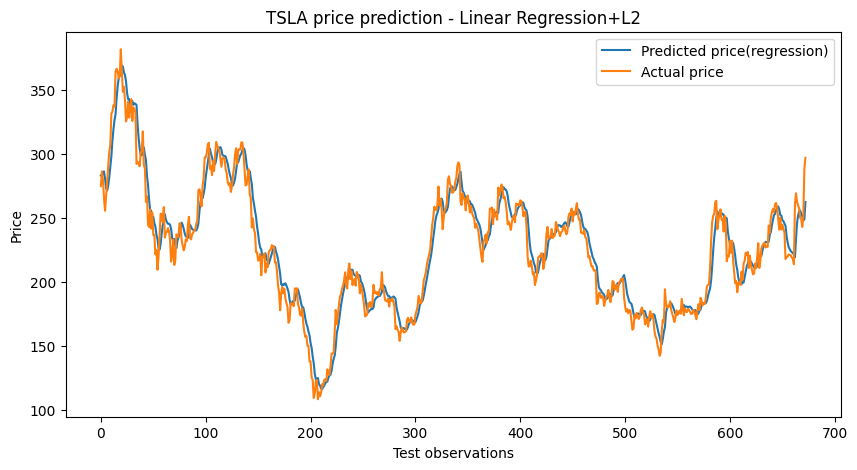

In [14]:
#Linear regression model with L2 penalty as a regularizer
linear_model = Ridge(alpha=1)
linear_model.fit(x_train, y_train)

# Make predictions using the linear regression model
linear_predictions = linear_model.predict(x_test)

#Rescale to original values again
rescaled_linear_predictions = scaler.inverse_transform(linear_predictions.reshape(-1, 1))
rescaled_test_values = scaler.inverse_transform(y_test.reshape(-1, 1))

#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_linear_predictions,label='Predicted price(regression)')
plt.plot(rescaled_test_values,label='Actual price')
plt.xlabel("Test observations")
plt.ylabel("Price")
plt.legend(loc="upper right")
plt.title("TSLA price prediction - Linear Regression+L2")
plt.show()

In [15]:
# Calculate MSE for Linear Regression model
mse_linear = mean_squared_error(rescaled_test_values, rescaled_linear_predictions)
r2_linear = r2_score(rescaled_test_values, rescaled_linear_predictions)

print(f"Mean Squared Error for Linear Regression model: {mse_linear}")
print(f"R-squared for Linear Regression model: {r2_linear}")

Mean Squared Error for Linear Regression model: 135.07217582601444
R-squared for Linear Regression model: 0.9420257650196534


In [36]:
#LSTM Model with dropout as regularizer method
model = Sequential([
    InputLayer(input_shape=(x_train.shape[1],1)),
    LSTM(256,return_sequences=True),
    Dropout(0.2),
    LSTM(256,return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(x_train,y_train,epochs=30,batch_size=128,verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 797,761 (3.04 MB)

 Trainable params: 797,761 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0107
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4161e-04
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3801e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.4130e-04
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7399e-04
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7554e-04
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.0295e-04
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3995e-04
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9780e-04
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.0944e-04
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6113e-04
Epoch 13/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.5228e-04
Epoch 14/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.3629e-04
Epoch 15/30
23/23 ━━━━━

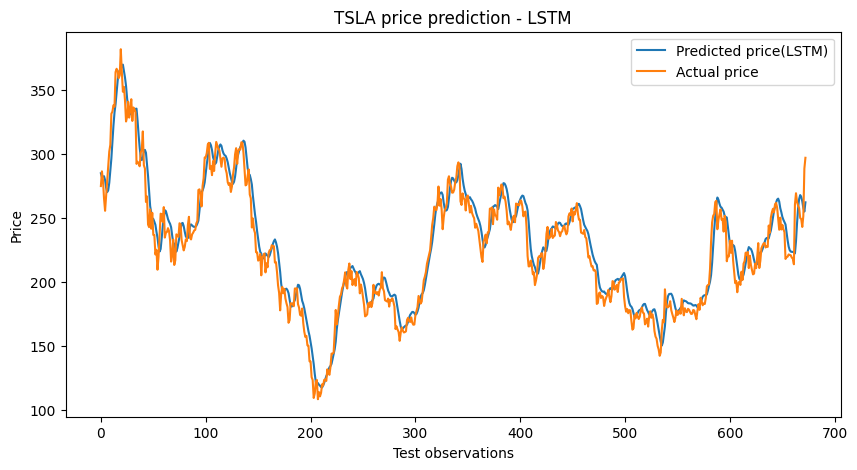

In [37]:
#Predict for test input
lstm_output = []
for i in range(len(x_test)):
  x_input = x_test[i].reshape(1,-1)
  y_pred = model.predict(x_input,verbose=0)
  lstm_output.append(y_pred[0][0])

#Rescale to original values again
rescaled_predict = scaler.inverse_transform(np.array(lstm_output).reshape(-1,1))
rescaled_test = scaler.inverse_transform(y_test.reshape(-1,1))

#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_predict,label='Predicted price(LSTM)')
plt.plot(rescaled_test,label='Actual price')
plt.xlabel("Test observations")
plt.ylabel("Price")
plt.legend(loc="upper right")
plt.title("TSLA price prediction - LSTM")
plt.show()

In [38]:
# Calculate MSE and R2 for LSTM model
mse_lstm = mean_squared_error(rescaled_test, rescaled_predict)
r2_lstm = r2_score(rescaled_test, rescaled_predict)

print(f"Mean Squared Error for LSTM model: {mse_lstm}")
print(f"R-squared for LSTM model: {r2_lstm}")

Mean Squared Error for LSTM model: 153.6135184943872
R-squared for LSTM model: 0.9340676481822379


In [39]:
#Extrapolation using LSTM model
x_input = x_test[0]
x_input = x_input.reshape((1, -1))

extrapolation = [] #Predicting future values by using predicited data as input (sliding window by 1 unit ahead)
for i in range(50):
  y_pred = model.predict(x_input,verbose=0)
  x_input = np.append(x_input,y_pred)
  x_input = x_input[1:]
  x_input = x_input.reshape((1, -1))
  extrapolation.append(y_pred[0][0])

true_y = y_test[:50] #True values
lstm_pred = lstm_output[:50] #From above model's prediction

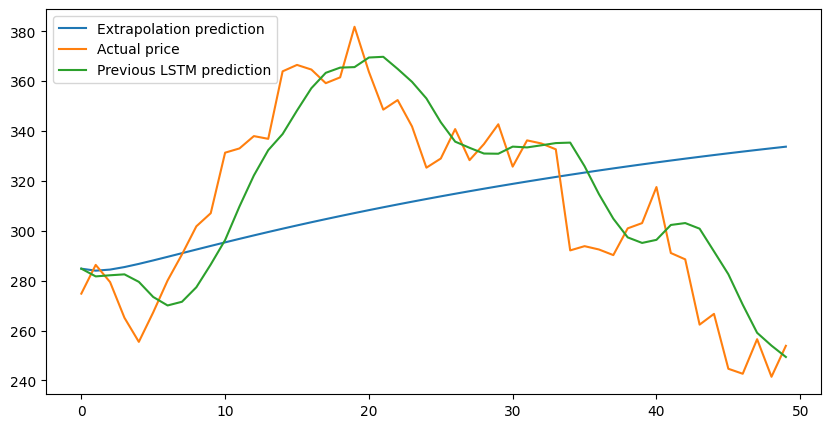

In [41]:
#Rescale to original values again
rescaled_extrapolation = scaler.inverse_transform(np.array(extrapolation).reshape(-1,1))
rescaled_true_y = scaler.inverse_transform(true_y.reshape(-1,1))
rescaled_prev_lstm_pred = scaler.inverse_transform(np.array(lstm_pred).reshape(-1,1))

#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_extrapolation,label='Extrapolation prediction')
plt.plot(rescaled_true_y,label='Actual price')
plt.plot(rescaled_prev_lstm_pred,label='Previous LSTM prediction')
plt.legend(loc="upper left")

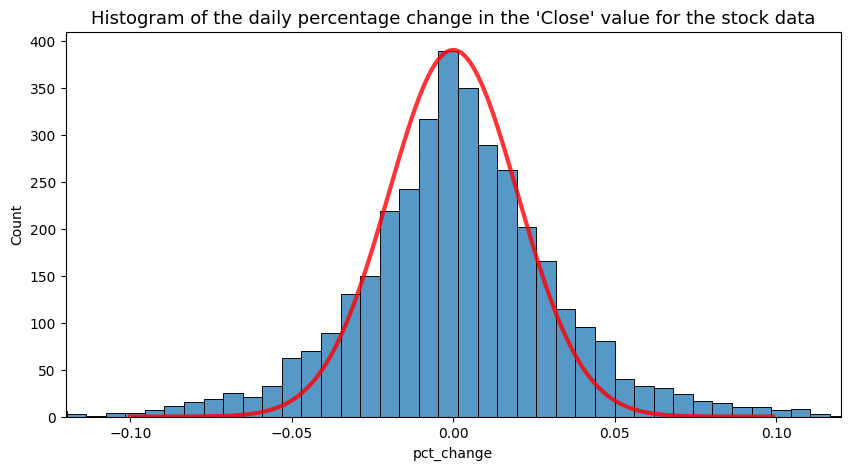

In [42]:
#What went wrong?
data['pct_change'] = data.Close.pct_change(periods = 1)
x = np.arange(-0.1, 0.1, 0.001)

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

plt.figure(figsize = (10,5))
ax = sns.histplot(data['pct_change'], binwidth=0.0061)

#Eye-picked values for gaussian parameters on the basis of which one fits histogram best
ax = plt.plot(x,Gaussian(x,0,0.02,390),color='r',lw=3,label='Gaussian #1', alpha=0.8)

plt.title("Histogram of the daily percentage change in the 'Close' value for the stock data", size=13)
plt.xlim(-0.12, 0.12);

In [ ]:
#Suggests that it's a random walk process (prev_day's value + some random error from a gaussian curve)